# Content consumption analysis

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit

import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import LinearRegression

In [2]:
def load_metadata_videos(file_path):
    return pd.read_csv(file_path).drop(columns=['Unnamed: 0','Unnamed: 0.1']).dropna()

In [4]:
file_path = os.path.join('data', 'derivatives','clean_viva.csv')
clean_df = load_metadata_videos(file_path)

In [5]:
clean_df.sample(3)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,duration_in_min,channel_category,classified_category,upload_year,duration_bin,likes_per_view,dislikes_per_view
185336,Education,UCwO_oNb9VQw-XO5JKupNDsQ,2019-11-12 22:56:23.253296,By Hafiz Ehsan Qadiri\n******\nFor More Video'...,3.0,VH65kX_Ea-Q,183,212.0,Quran e Kareem se Nabi ﷺ ki Shaan Ghataane Waa...,Quran e Kareem se Nabi ﷺ ki Shaan Ghataane Waa...,2018-02-28 00:00:00,2304.0,3.050000,Education,Edutainment,2018,0-5,0.092014,0.001302
200936,Education,UCPnmMGBRhma0R6Ji3-6MkUQ,2019-11-19 03:17:50.040673,Johns Twitter: https://twitter.com/officialmca...,44.0,OU33s__Eh0I,456,237.0,"verge,verge exploding,verge price increase,ver...",WHY VERGE WILL HIT $15 in 2018!,2017-12-23 00:00:00,46055.0,7.600000,Education,Edutainment,2017,5-10,0.005146,0.000955
103819,Education,UCdCDj4v4eWN5kvVCeJ1KgXA,2019-11-20 21:57:58.934444,Commodore 64 drive emulator build Live Stream!...,2.0,_NtLqHfJCsg,5225,33.0,"@backofficeshow,Andrew Armstrong,pi5141,commod...",Commodore 64 drive emulator build Live Stream!...,2018-08-21 00:00:00,1463.0,87.083333,Science & Technology,Programming,2018,60-90,0.022556,0.001367


In [6]:
clean_df.columns

Index(['categories', 'channel_id', 'crawl_date', 'description',
       'dislike_count', 'display_id', 'duration', 'like_count', 'tags',
       'title', 'upload_date', 'view_count', 'duration_in_min',
       'channel_category', 'classified_category', 'upload_year',
       'duration_bin', 'likes_per_view', 'dislikes_per_view'],
      dtype='object')

In [95]:
def analyze_trends(df_education, classification_type):
    if classification_type not in ['channel_category', 'classified_category']:
        raise ValueError("classification_type must be either 'channel_category' or 'classified_category'")

    # Ensure upload_date is in datetime format
    df_education['upload_date'] = pd.to_datetime(df_education['upload_date'])

    # Bar plot: Number of videos per category per year
    yearly_data = df_education.groupby(['upload_year', classification_type]).size().reset_index(name='video_count')
    yearly_data['upload_year'] = yearly_data['upload_year'].apply(lambda x: str(x))
    yearly_data = yearly_data.sort_values(['video_count']).reset_index(drop=True)
    plt.figure(figsize=(15, 7))
    sns.barplot(
        data=yearly_data,
        x=classification_type,
        y='video_count',
        hue='upload_year',
        dodge=True
    )
    plt.title('Number of Videos per Category per Year')
    plt.ylabel('Number of Videos')
    plt.yscale('log')
    plt.xlabel('Year')
    plt.legend(title=classification_type)
    plt.show()
    
    # Group by classification and time for aggregated analysis
    grouped = df_education.groupby([
        pd.Grouper(key='upload_date', freq='M'), classification_type
    ]).agg({
        'view_count': 'sum',
        'like_count': 'sum',
        'dislike_count': 'sum',
        'duration': 'sum',
        'channel_id': 'count'  # Counts the number of videos
    }).rename(columns={'channel_id': 'video_count'}).reset_index()

    # Trend Analysis: Number of videos, total duration, views, likes, dislikes over time
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=grouped, x='upload_date', y='video_count', hue=classification_type, marker='o')
    plt.title('Number of Videos Over Time by Category')
    plt.ylabel('Number of Videos')
    plt.xlabel('Time')
    plt.legend(title=classification_type)
    plt.show()

    # Seasonality Analysis: When people post each type of category
    k = 1
    plt.figure(figsize=(15,5))
    for category in df_education[classification_type].unique():
        category_data = grouped[grouped[classification_type] == category]
        if len(category_data) > 12:  # Ensure enough data for seasonality analysis
            plt.subplot(1, 3, k)
            result = seasonal_decompose(category_data['video_count'], model='additive', period=12)
            plt.plot(result.observed, label="Observed", color='blue')
            plt.plot(result.trend, label="Trend", color='orange')
            plt.plot(result.seasonal, label="Seasonal", color='green')
            plt.xticks(ticks=np.arange(0,480,120), labels=np.arange(2015, 2019), rotation=30, fontsize=10, ha='right')
            plt.title(category, fontsize=15)
            plt.ylabel('Scores', fontsize=12)
            plt.xlabel('Year', fontsize=12)
            plt.legend(loc='upper left')
            k += 1
        if k > 3:
            plt.show()
            k=1
            plt.figure(figsize=(15,5))
        
    

    # Emerging/Declining Categories: Percent change
    grouped['percent_change_videos'] = grouped.groupby(classification_type)['video_count'].pct_change() * 100
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=grouped, x='upload_date', y='percent_change_videos', hue=classification_type)
    plt.title('Percent Change in Number of Videos Over Time')
    plt.ylabel('Percent Change (%)')
    plt.xlabel('Time')
    plt.legend(title=classification_type)
    plt.show()

    # Popularity Analysis: Like/views and dislike/views over time and category
    grouped['likes_per_view'] = grouped['like_count'] / grouped['view_count']
    grouped['dislikes_per_view'] = grouped['dislike_count'] / grouped['view_count']

    plt.figure(figsize=(15, 7))
    sns.lineplot(data=grouped, x='upload_date', y='likes_per_view', hue=classification_type)
    plt.title('Likes per View Over Time by Category')
    plt.ylabel('Likes per View')
    plt.xlabel('Time')
    plt.legend(title=classification_type)
    plt.show()

    plt.figure(figsize=(15, 7))
    sns.lineplot(data=grouped, x='upload_date', y='dislikes_per_view', hue=classification_type)
    plt.title('Dislikes per View Over Time by Category')
    plt.ylabel('Dislikes per View')
    plt.xlabel('Time')
    plt.legend(title=classification_type)
    plt.show()

    # Views per minute over time and category
    grouped['views_per_minute'] = grouped['view_count'] / (grouped['duration'] / 60)

    plt.figure(figsize=(15, 7))
    sns.lineplot(data=grouped, x='upload_date', y='views_per_minute', hue=classification_type)
    plt.title('Views per Minute Over Time by Category')
    plt.ylabel('Views per Minute')
    plt.xlabel('Time')
    plt.legend(title=classification_type)
    plt.show()

    # Views per category over time
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=grouped, x='upload_date', y='view_count', hue=classification_type)
    plt.title('Views Over Time by Category')
    plt.ylabel('Views')
    plt.xlabel('Time')
    plt.legend(title=classification_type)
    plt.show()

    # Exponential Fits: Number of videos and durations
    # def exp_fit(data):
    #     x = np.arange(len(data)).reshape(-1, 1)
    #     y = np.log1p(data)  # Use log1p to handle zero values

    #     model = LinearRegression()
    #     model.fit(x, y)
    #     y_pred = np.expm1(model.predict(x))  # Reverse log transformation
    #     return y_pred, model.coef_[0]  # Return predicted values and slope

    def exp_fit(col):

        def exponential_model(x, a, b):
            return a * np.exp(b * x)
        
        x = np.arange(col.shape[0])
        x = x / np.max(x)
        popt, pcov = curve_fit(exponential_model, x, col)
        a, b = popt
        y_fit = exponential_model(x, a, b)
        return y_fit, a
    
    plt.figure(figsize=(15, 6))
    slopes = {}
    for category in df_education[classification_type].unique():
        category_data = grouped[grouped[classification_type] == category]
        if len(category_data) > 0:
            predicted, slope = exp_fit(category_data['video_count'])
            slopes[category] = slope
            plt.plot(category_data['upload_date'], predicted, label=f'{category} (Slope: {slope:.2f})')

    plt.title('Exponential Fit for Number of Videos by Category')
    plt.ylabel('Number of Videos (Exponential Fit)')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

    print("Exponential Growth Slopes:")
    for category, slope in slopes.items():
        print(f"{category}: {slope:.5f}")

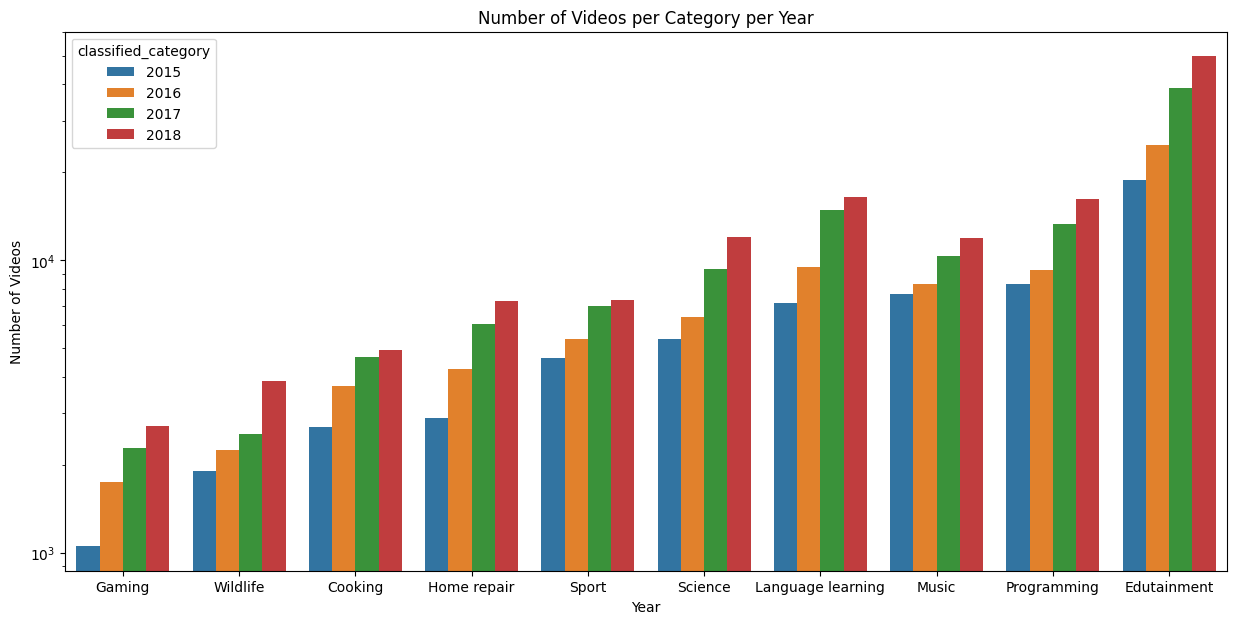

C:\Users\Flori\AppData\Local\Temp\ipykernel_49304\2697887849.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(key='upload_date', freq='M'), classification_type


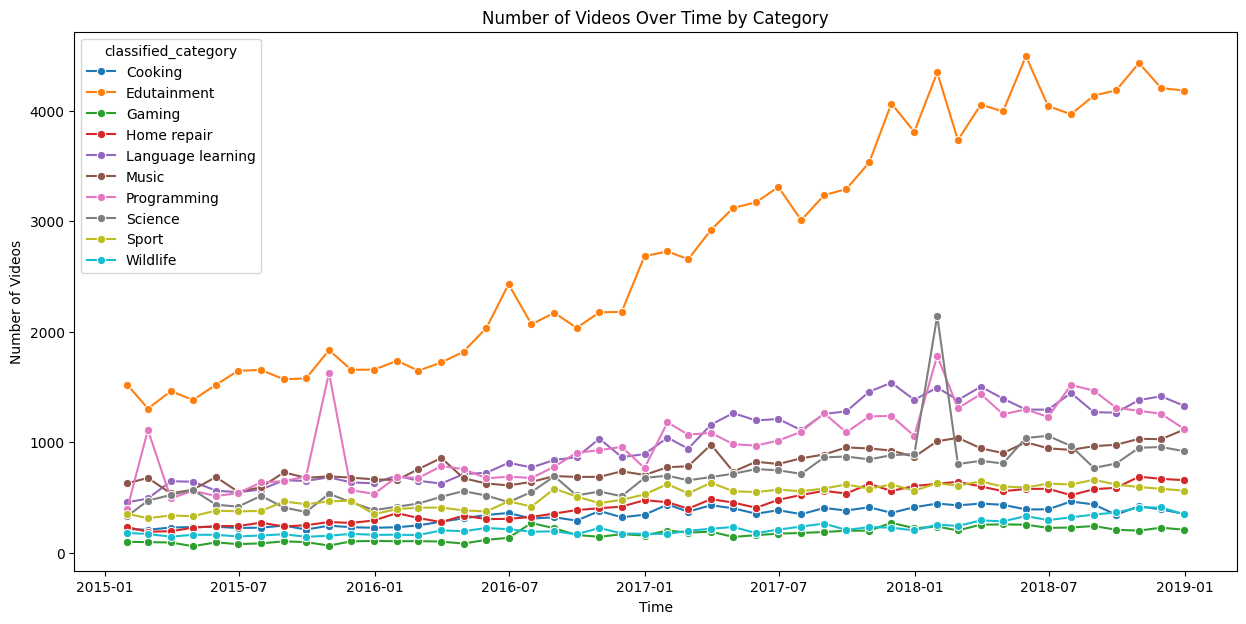

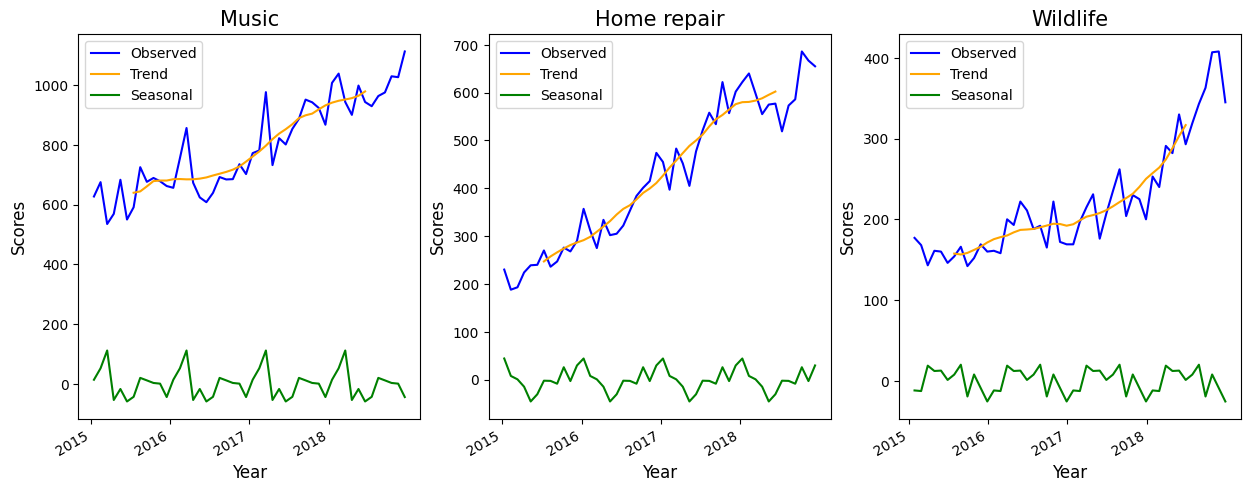

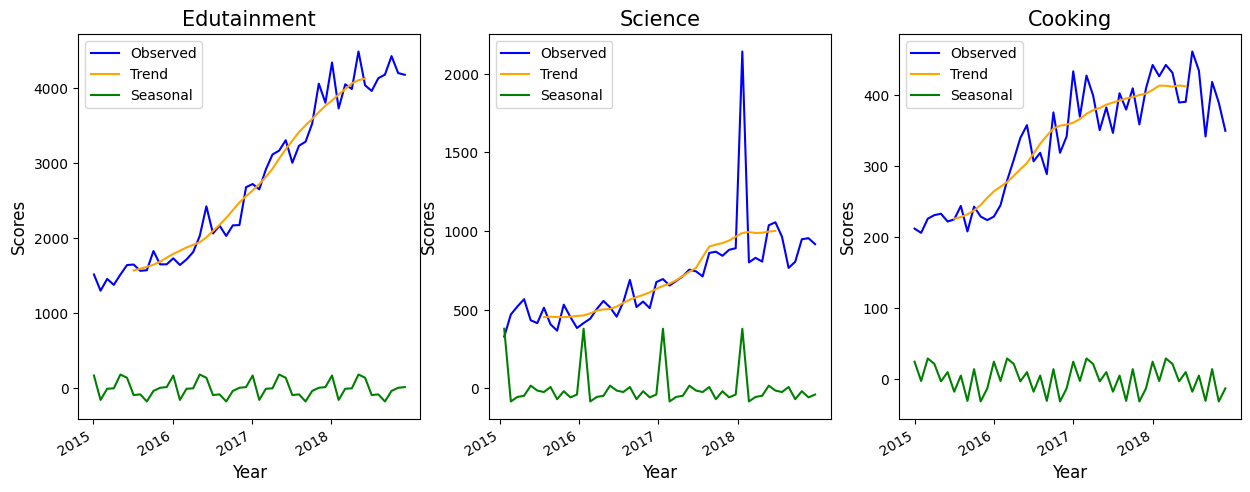

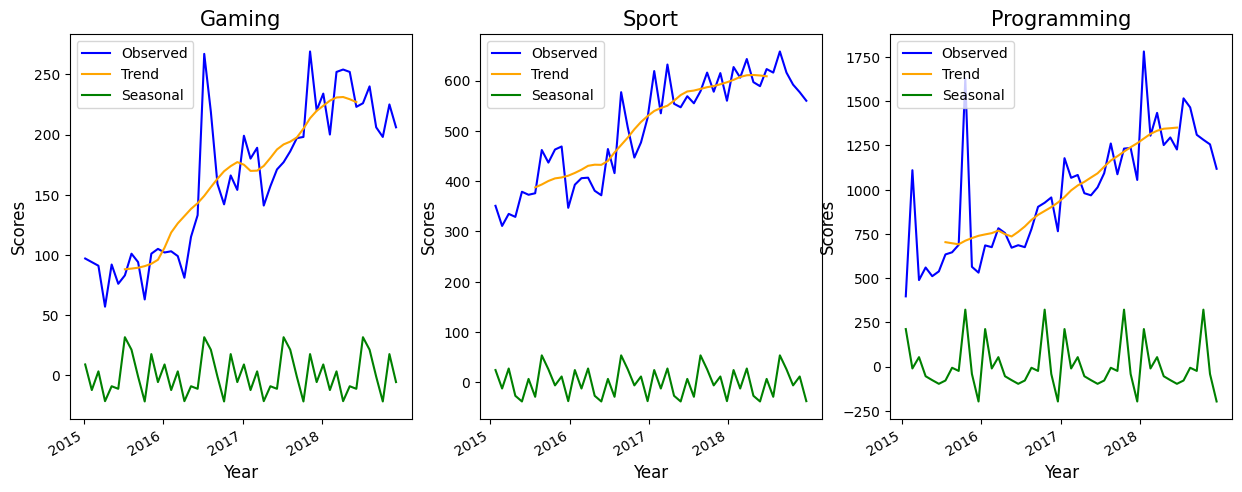

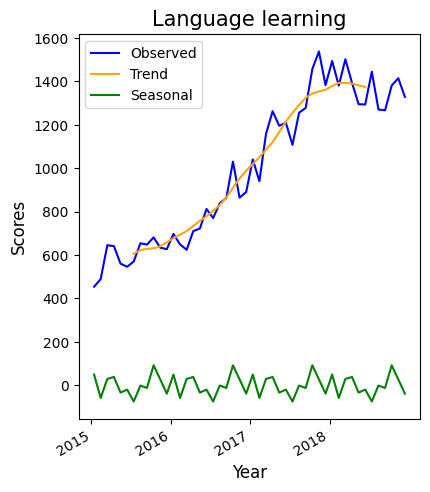

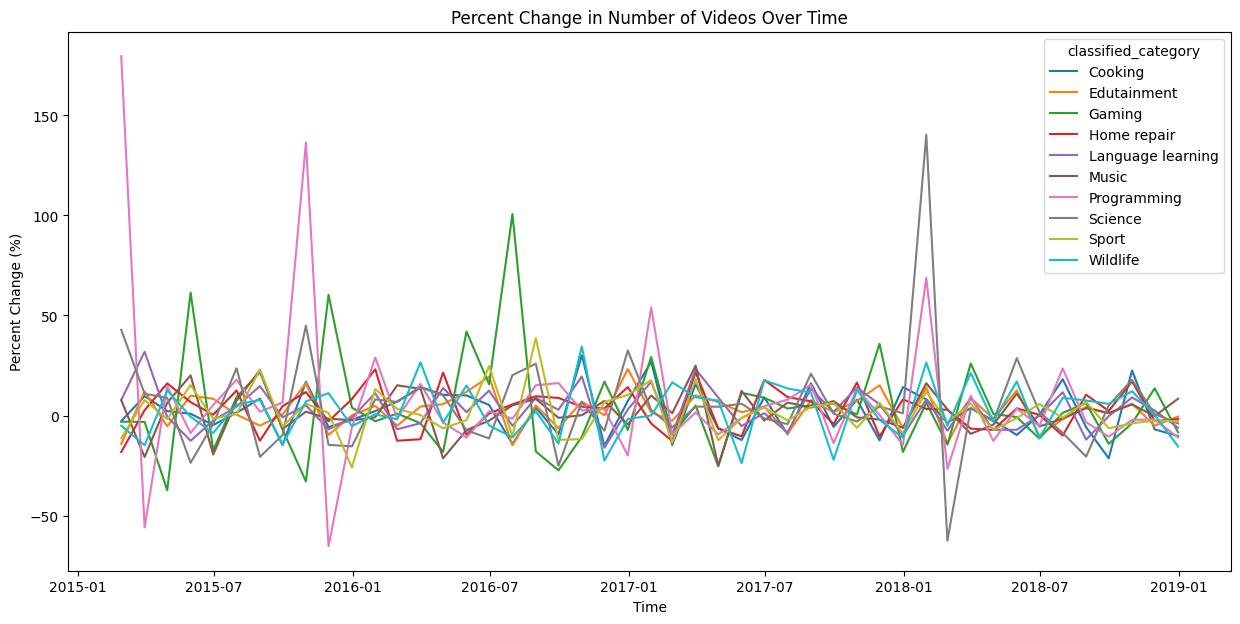

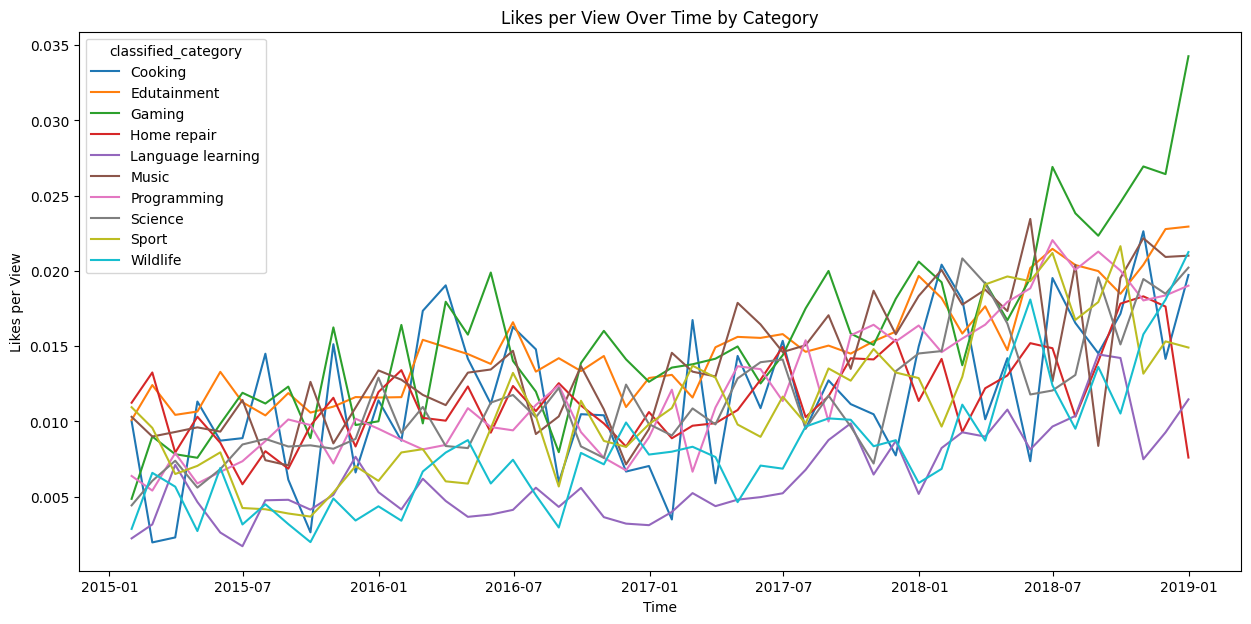

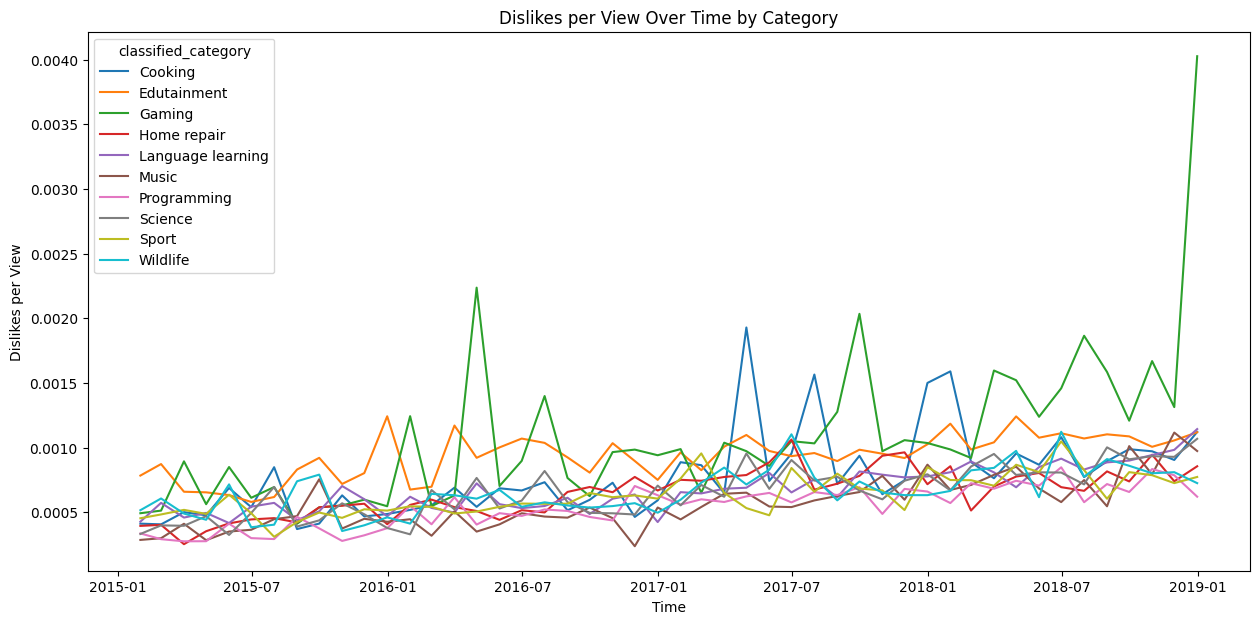

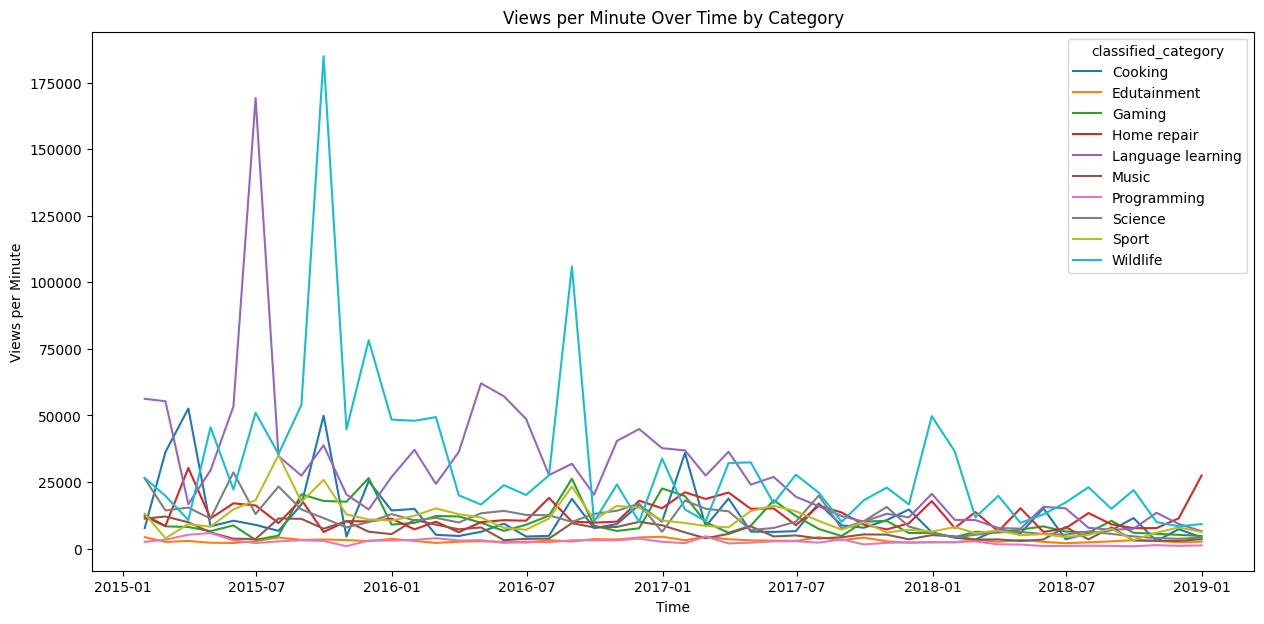

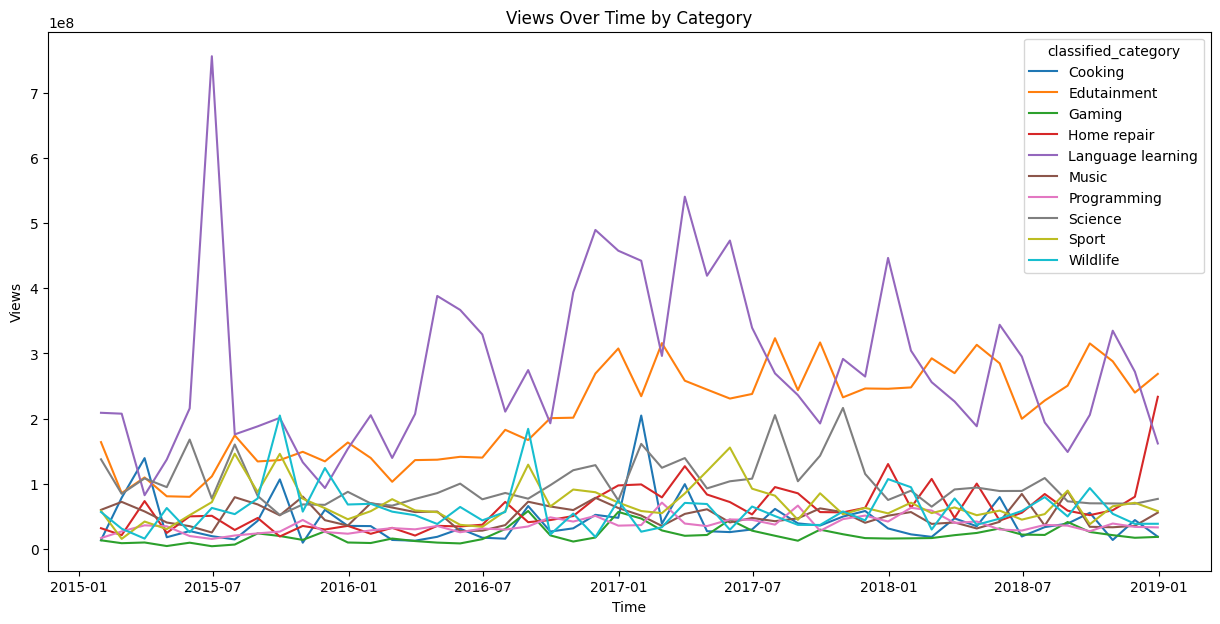

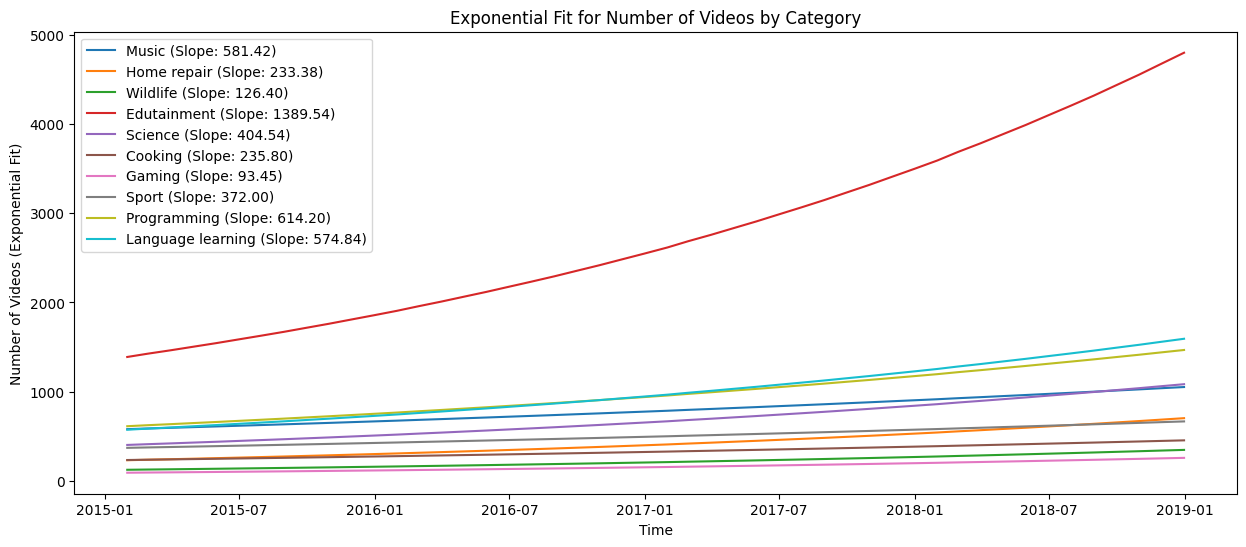

Exponential Growth Slopes:
Music: 581.42116
Home repair: 233.38294
Wildlife: 126.39551
Edutainment: 1389.54077
Science: 404.53551
Cooking: 235.80030
Gaming: 93.45283
Sport: 371.99962
Programming: 614.20087
Language learning: 574.84201


In [96]:
analyze_trends(df_education_viva, classification_type='classified_category')